## Welcome to the  Watt Wise Intelligent Time Series Energy Consumption Forecasting project 


In [1]:
# import  libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.simplefilter(action= 'ignore')

In [2]:
df = pd.read_csv("/Users/sot/Downloads/Energy_consumption.csv",index_col = 'Timestamp')

In [3]:
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [4]:
df.index

Index(['2022-01-01 00:00:00', '2022-01-01 01:00:00', '2022-01-01 02:00:00',
       '2022-01-01 03:00:00', '2022-01-01 04:00:00', '2022-01-01 05:00:00',
       '2022-01-01 06:00:00', '2022-01-01 07:00:00', '2022-01-01 08:00:00',
       '2022-01-01 09:00:00',
       ...
       '2022-02-11 06:00:00', '2022-02-11 07:00:00', '2022-02-11 08:00:00',
       '2022-02-11 09:00:00', '2022-02-11 10:00:00', '2022-02-11 11:00:00',
       '2022-02-11 12:00:00', '2022-02-11 13:00:00', '2022-02-11 14:00:00',
       '2022-02-11 15:00:00'],
      dtype='object', name='Timestamp', length=1000)

In [5]:
## Converting the index values to proper datetime objects.

df.index = pd.to_datetime(df.index)

In [6]:
## seting  the frequency of the DateTimeIndex  to  hourly frequency.

df.index.freq = "H"

In [7]:
df.index

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 01:00:00',
               '2022-01-01 02:00:00', '2022-01-01 03:00:00',
               '2022-01-01 04:00:00', '2022-01-01 05:00:00',
               '2022-01-01 06:00:00', '2022-01-01 07:00:00',
               '2022-01-01 08:00:00', '2022-01-01 09:00:00',
               ...
               '2022-02-11 06:00:00', '2022-02-11 07:00:00',
               '2022-02-11 08:00:00', '2022-02-11 09:00:00',
               '2022-02-11 10:00:00', '2022-02-11 11:00:00',
               '2022-02-11 12:00:00', '2022-02-11 13:00:00',
               '2022-02-11 14:00:00', '2022-02-11 15:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=1000, freq='h')

In [8]:
## MIN AND MAX TIMESTAMP

print("Minimum timestamp:", df.index.min())
print("Maximum timestamp:", df.index.max())


Minimum timestamp: 2022-01-01 00:00:00
Maximum timestamp: 2022-02-11 15:00:00


In [9]:
## Replacing the dayofweek with the actual day of the week. 

df['DayOfWeek'] = df.index.day_name()

In [10]:
df.head(4)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Saturday,No,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Saturday,No,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Saturday,No,56.519850


# Exploratory Data Analysis on Categorical Features

In [11]:
df['DayOfWeek'].value_counts()


DayOfWeek
Saturday     144
Sunday       144
Monday       144
Tuesday      144
Wednesday    144
Thursday     144
Friday       136
Name: count, dtype: int64

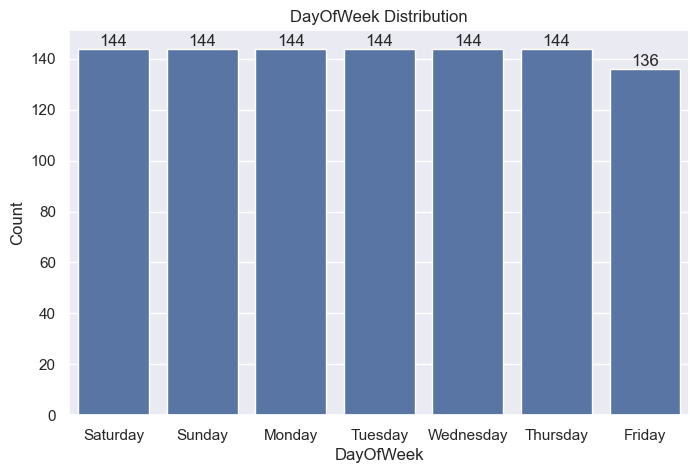

In [12]:
Day_counts = df['DayOfWeek'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
day = sns.countplot(data=df, x='DayOfWeek', order=Day_counts.index)

for p in day.patches:
    day.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("DayOfWeek Distribution")
plt.xlabel("DayOfWeek")
plt.ylabel("Count")
plt.show()

In [13]:
df['HVACUsage'].value_counts()

HVACUsage
Off    508
On     492
Name: count, dtype: int64

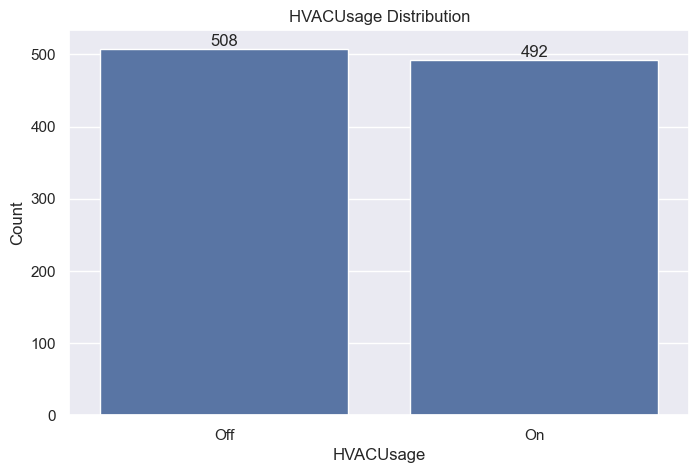

In [14]:
HVACUsage_counts = df['HVACUsage'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
HVACUsage = sns.countplot(data=df, x='HVACUsage', order=HVACUsage_counts.index)

for p in HVACUsage.patches:
    HVACUsage.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("HVACUsage Distribution")
plt.xlabel("HVACUsage")
plt.ylabel("Count")
plt.show()

In [15]:
df['LightingUsage'].value_counts()

LightingUsage
Off    509
On     491
Name: count, dtype: int64

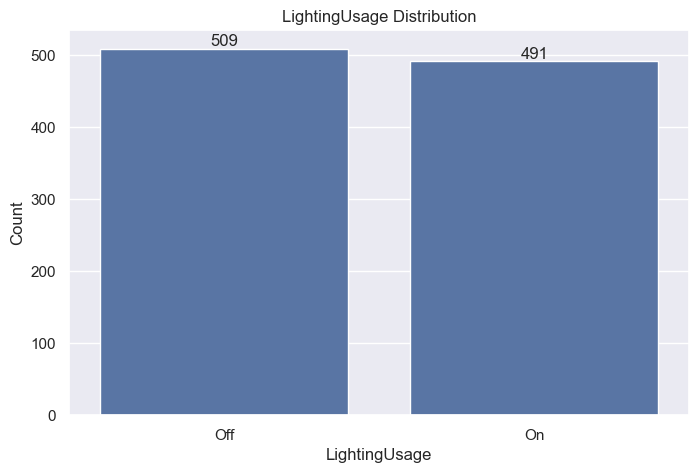

In [16]:
LightingUsage_counts = df['LightingUsage'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
LightingUsage = sns.countplot(data=df, x='LightingUsage', order=LightingUsage_counts.index)

for p in LightingUsage.patches:
    LightingUsage.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("LightingUsage Distribution")
plt.xlabel("LightingUsage")
plt.ylabel("Count")
plt.show()

In [17]:
df['Holiday'].value_counts()

Holiday
No     533
Yes    467
Name: count, dtype: int64

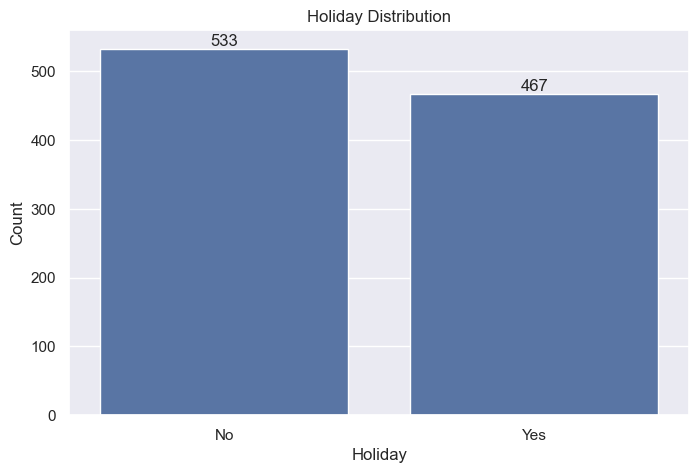

In [18]:
Holiday_counts = df['Holiday'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
Holiday = sns.countplot(data=df, x='Holiday', order=Holiday_counts.index)

for p in Holiday.patches:
    Holiday.annotate(
        f'{int(p.get_height())}',  
        (p.get_x() + p.get_width() / 2, p.get_height()),  
        ha='center',  
        va='bottom'  
    )

plt.title("Holiday Distribution")
plt.xlabel("Holiday")
plt.ylabel("Count")
plt.show()

## Insight

Based on the exploratory data analysis (EDA), the categorical features appear to be evenly distributed. To prepare the data and preserve potential inherent order (especially for features like DayOfWeek), I'll use the OrdinalEncoder to convert the categorical variables into numerical format with a predefined, meaningful order.

## Relationship between EnergyConsumption and Categorical Features

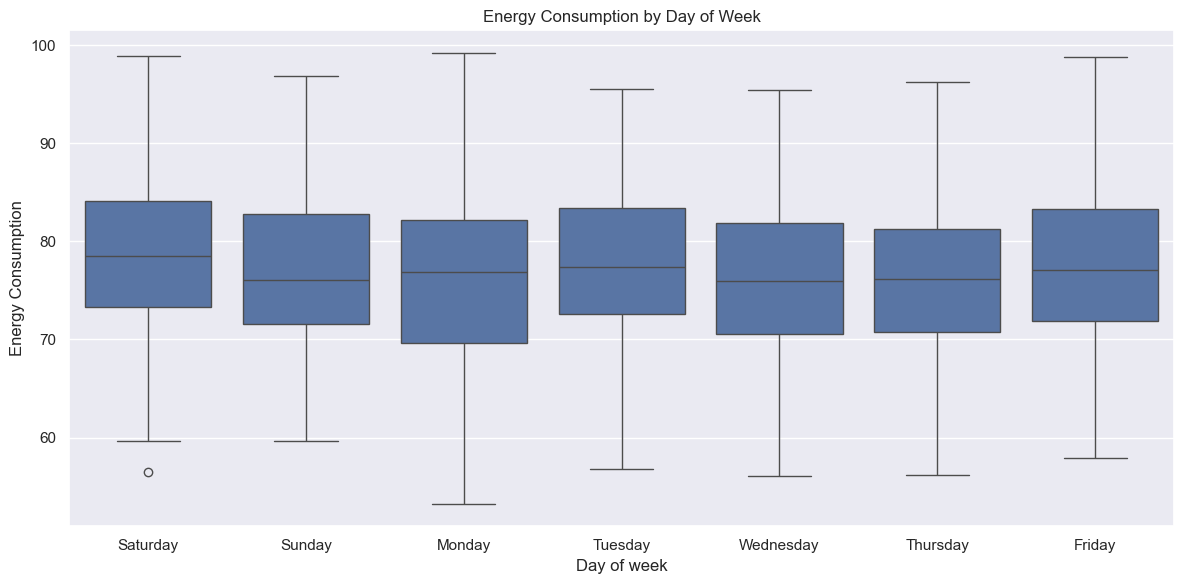

In [19]:


plt.figure(figsize=(12, 6))  
sns.boxplot(x='DayOfWeek', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by Day of Week')
plt.xlabel('Day of week')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

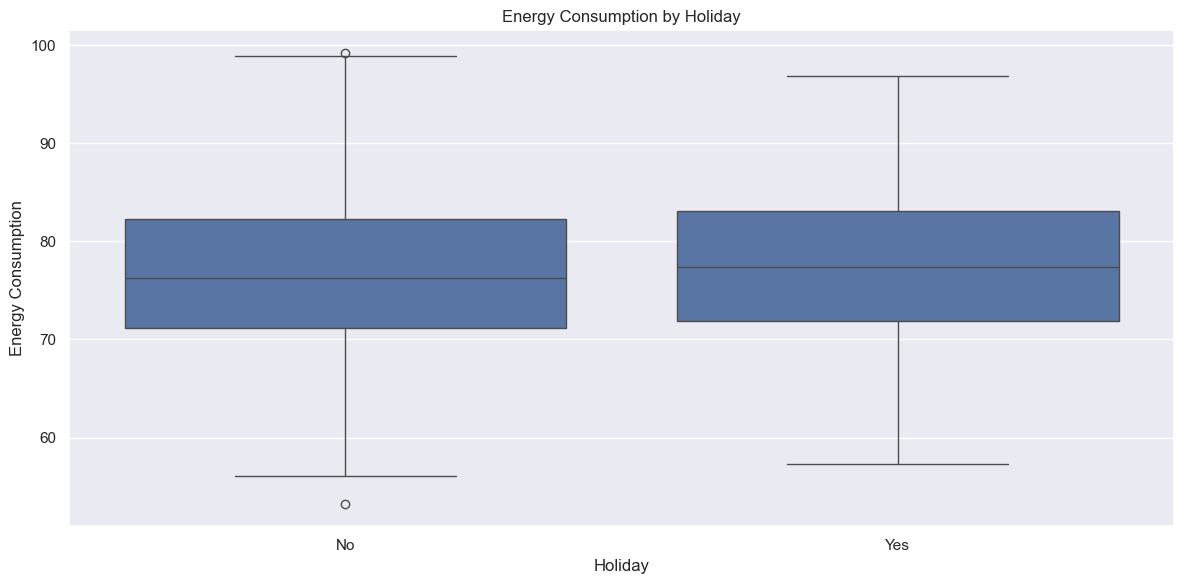

In [20]:

plt.figure(figsize=(12, 6))  
sns.boxplot(x='Holiday', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

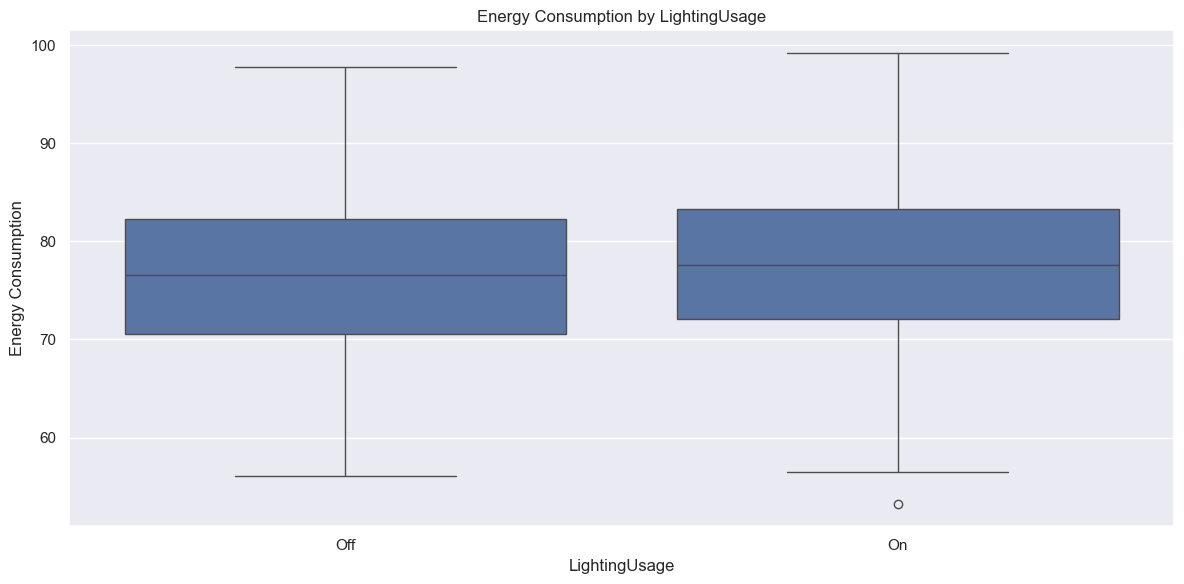

In [21]:
plt.figure(figsize=(12, 6))  
sns.boxplot(x='LightingUsage', y='EnergyConsumption', data=df)
plt.title('Energy Consumption by LightingUsage')
plt.xlabel('LightingUsage')
plt.ylabel('Energy Consumption')
plt.tight_layout()
plt.show()

In [22]:
## Using ordinal Encoder for the categorical Features

categories = [
    ['Off', 'On'],                      
    ['Off', 'On'],                       
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ['No', 'Yes']                        
]

encoder = OrdinalEncoder(categories=categories)
categorical_cols = ['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday']
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])



In [23]:
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,1.0,0.0,2.774699,5.0,0.0,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,1.0,1.0,21.831384,5.0,0.0,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,0.0,0.0,6.764672,5.0,0.0,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,0.0,1.0,8.623447,5.0,0.0,56.519850
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,1.0,0.0,3.071969,5.0,0.0,70.811732


# Exploratory Data Analysis on Numerical Features

### Exploring deeply  the Energyconsumption variable 

<Axes: xlabel='Timestamp'>

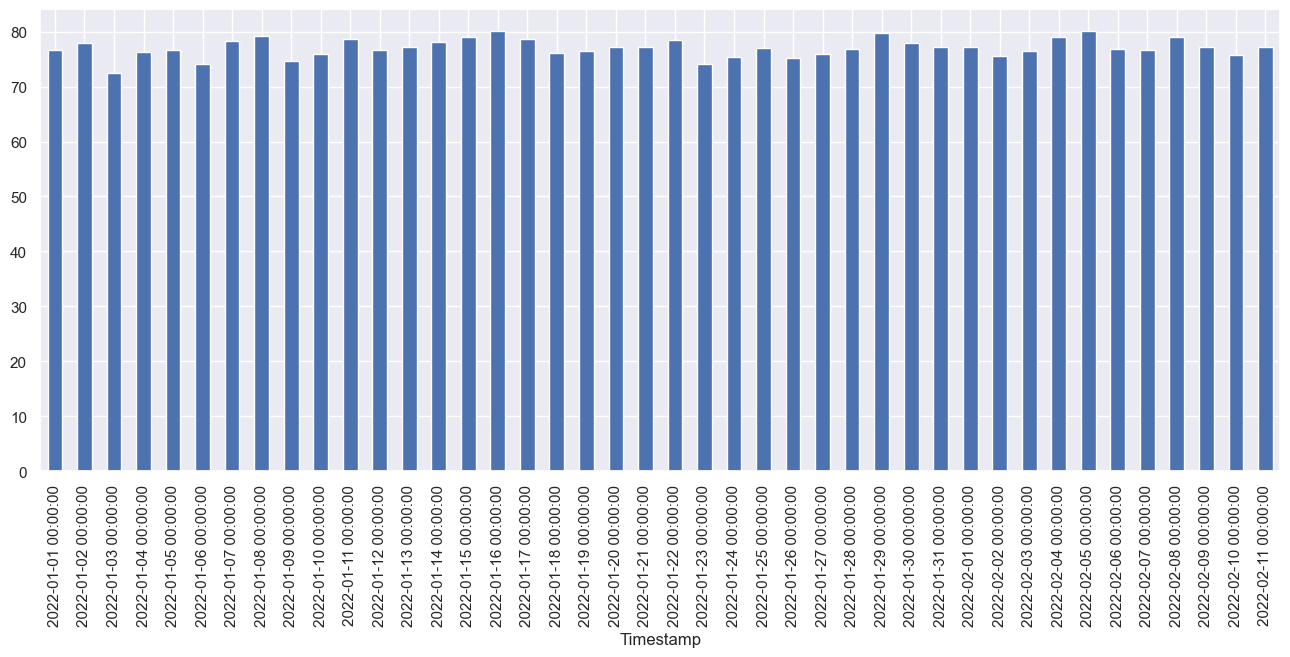

In [24]:
df['EnergyConsumption'].resample('D').mean().plot.bar(figsize=(16,6))

<Axes: xlabel='Timestamp'>

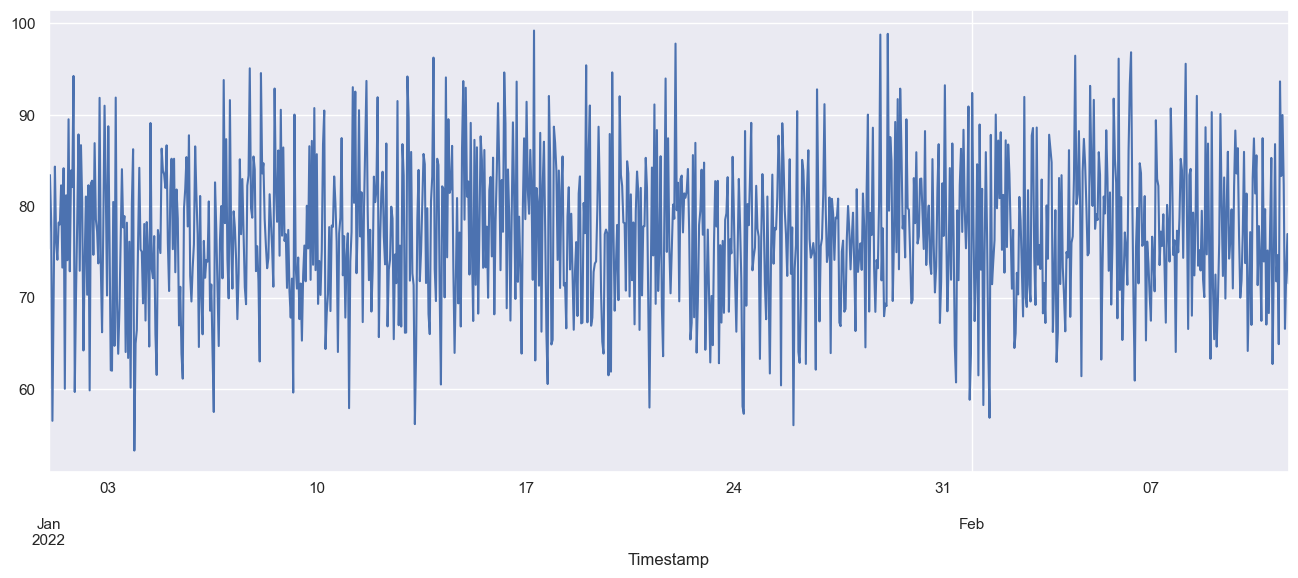

In [26]:
df['EnergyConsumption'].plot(figsize=(16,6))

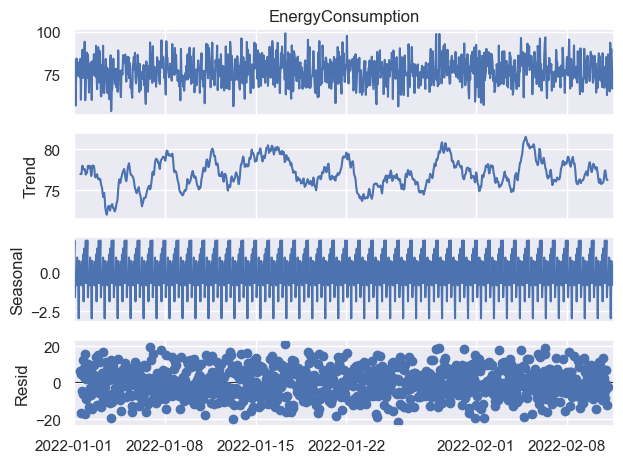

In [14]:
## checking the ETS decomposition

result = seasonal_decompose(df['EnergyConsumption'], model='additive', period=24) 
result.plot();
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Average Energy Consumption by Hour'}, xlabel='Hour'>

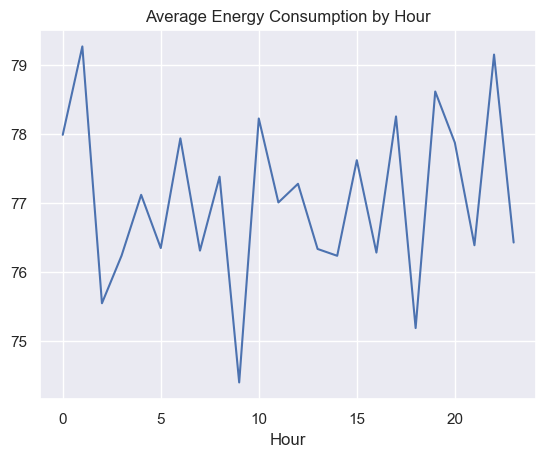

In [28]:


df['Hour'] = df.index.hour
df.groupby('Hour')['EnergyConsumption'].mean().plot(kind='line', title='Average Energy Consumption by Hour')



# SMA - Simple Moving Average

In [29]:
df['7-day-SMA'] = df['EnergyConsumption'].rolling(window=7).mean()
df['14-day-SMA'] = df['EnergyConsumption'].rolling(window=14).mean()

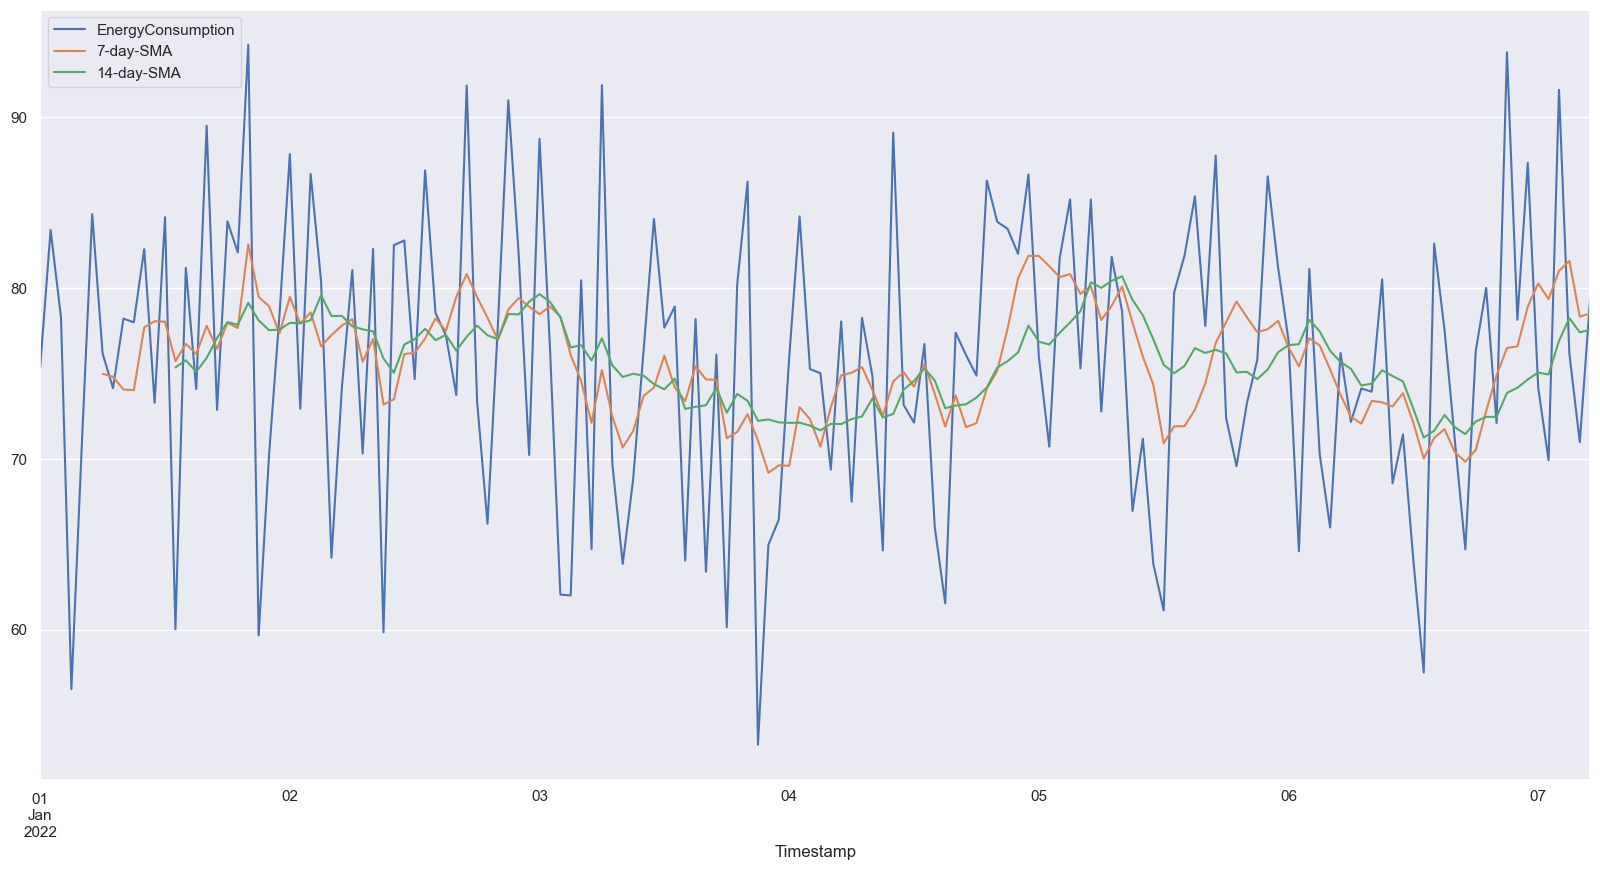

In [30]:
df[['EnergyConsumption','7-day-SMA', '14-day-SMA']].iloc[:150].plot(figsize = (20,10));

## EWMA - Exponentially Weighted Moving Average

In [31]:
df['EWMA-14'] =  df['EnergyConsumption'].ewm(span = 14).mean()

<Axes: xlabel='Timestamp'>

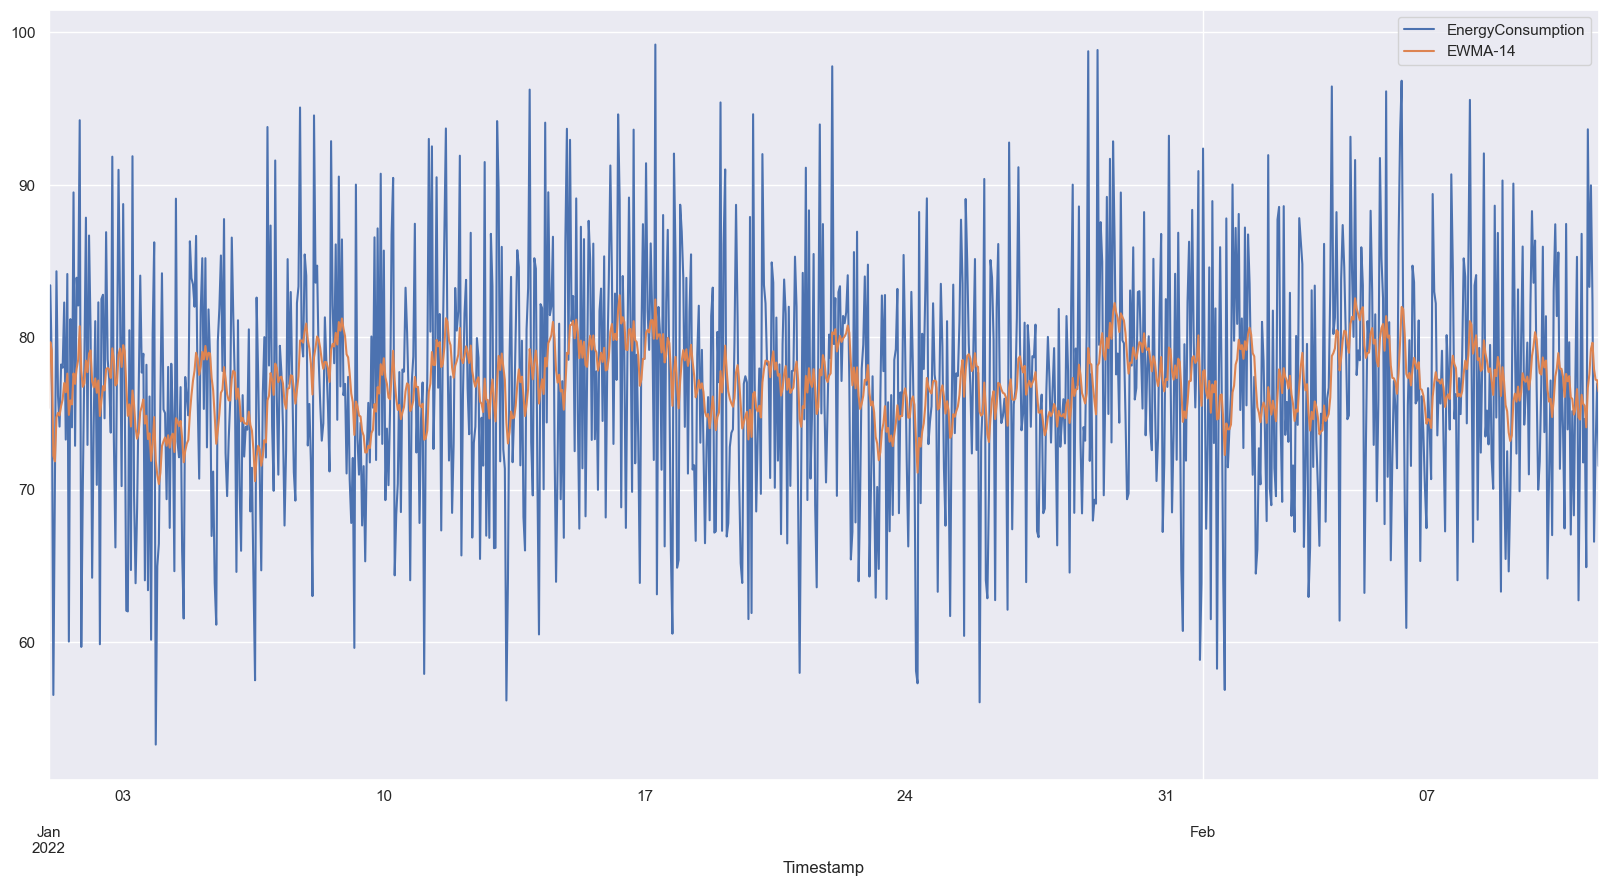

In [32]:
 df[['EnergyConsumption','EWMA-14']].plot(figsize=(20,10))

# SES - Simple Exponential Smoothing

In [36]:
span = 14
alpha = 2/(span+1)

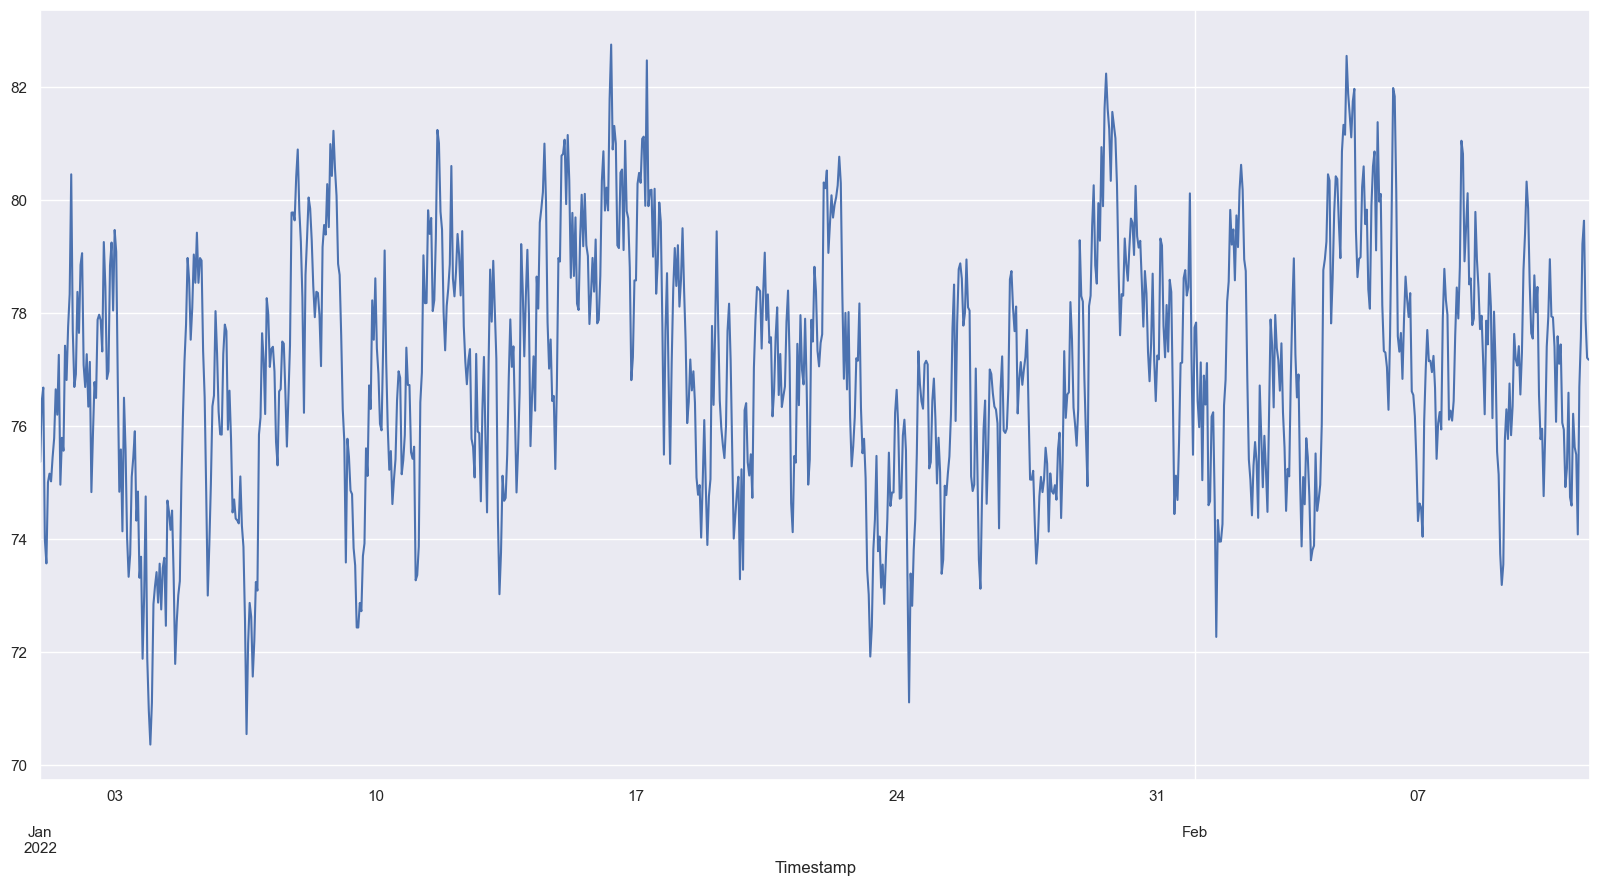

In [37]:
df['SES14'] = SimpleExpSmoothing(df['EnergyConsumption']).fit(smoothing_level = alpha,optimized=False).fittedvalues.shift(-1).plot(figsize = (20,10))

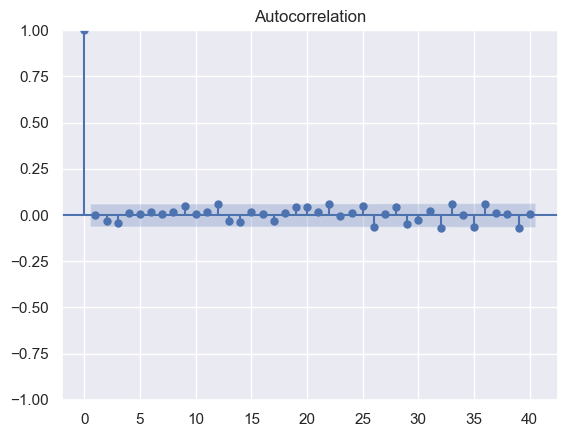

In [58]:
plot_acf(df['EnergyConsumption'],lags = 40);

##  visualizing  relationship between numerical features  and EnergyConsumption

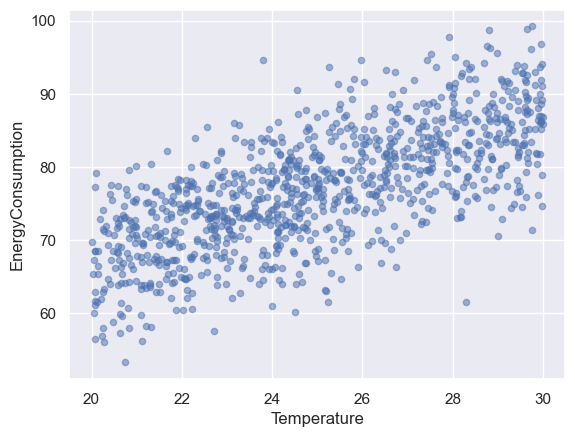

In [17]:
df.plot(x='Temperature', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()


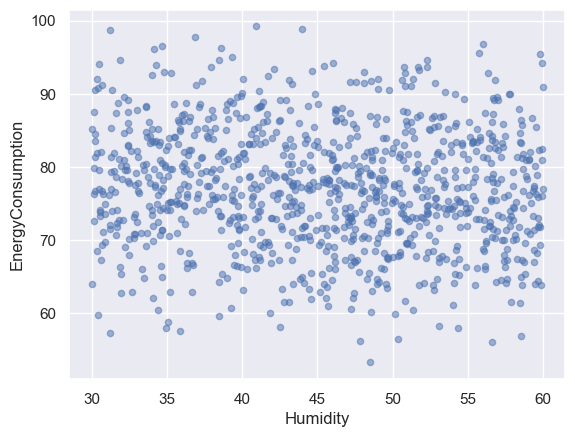

In [41]:
df.plot(x='Humidity', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

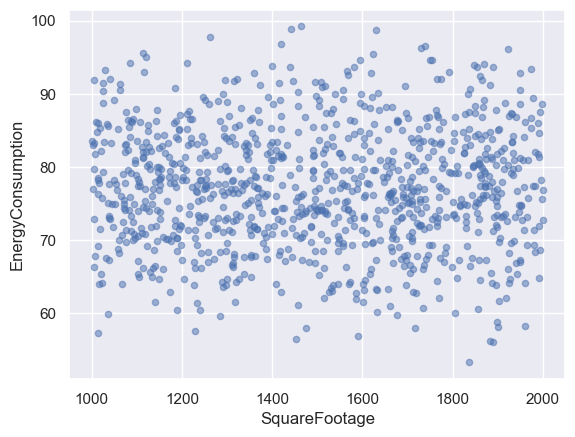

In [43]:
df.plot(x='SquareFootage', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

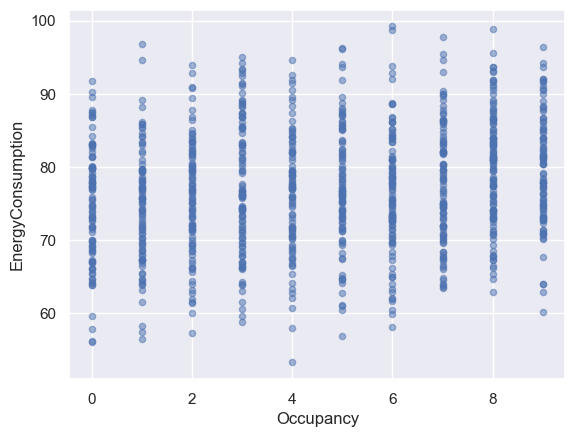

In [44]:
df.plot(x='Occupancy', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

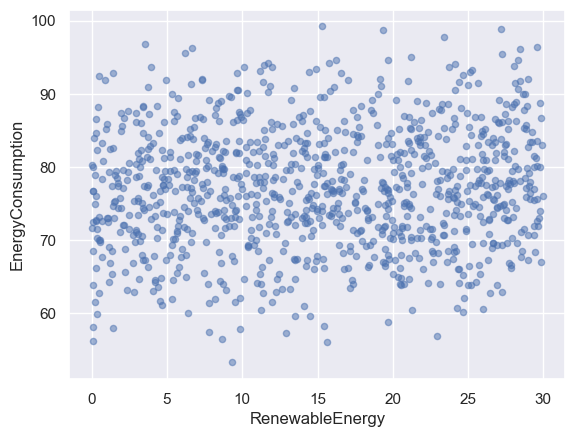

In [45]:
df.plot(x='RenewableEnergy', y='EnergyConsumption', kind='scatter', alpha=0.5)
plt.show()

## Insight 

From the exploratory data analysis (EDA), it is evident that Temperature shows a noticeable relationship with EnergyConsumption. However, it is important to remember that correlation does not imply causation. To further investigate whether this relationship is causal, I will perform statistical tests to assess the potential causality between these features.

## performing Granger Causality Test to check whether numerical features  can be used to predict EnergyConsumption.

# Granger causality test 

In [50]:
grangercausalitytests(df[['EnergyConsumption', 'Temperature']], maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0015  , p=0.9692  , df=1
likelihood ratio test: chi2=0.0015  , p=0.9692  , df=1
parameter F test:         F=0.0015  , p=0.9693  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.0104  , p=0.9948  , df=2
likelihood ratio test: chi2=0.0104  , p=0.9948  , df=2
parameter F test:         F=0.0052  , p=0.9948  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=0.1598  , p=0.9838  , df=3
likelihood ratio test: chi2=0.1597  , p=0.9838  , df=3
parameter F test:         F=0.0529  , p=0.9840  , df_denom=990, df_num=3


In [51]:
grangercausalitytests(df[['Occupancy','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0232  , p=0.8789  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0233  , p=0.8787  , df=1
likelihood ratio test: chi2=0.0233  , p=0.8787  , df=1
parameter F test:         F=0.0232  , p=0.8789  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3557  , p=0.7007  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.7151  , p=0.6994  , df=2
likelihood ratio test: chi2=0.7148  , p=0.6995  , df=2
parameter F test:         F=0.3557  , p=0.7007  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6727  , p=0.5688  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=2.0325  , p=0.5657  , df=3
likelihood ratio test: chi2=2.0304  , p=0.5661  , df=3
parameter F test:         F=0.6727  , p=0.5688  , df_denom=990, df_num=3


In [52]:
grangercausalitytests(df[['Humidity','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0430  , p=0.8358  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0431  , p=0.8355  , df=1
likelihood ratio test: chi2=0.0431  , p=0.8355  , df=1
parameter F test:         F=0.0430  , p=0.8358  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0610  , p=0.9409  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.1226  , p=0.9406  , df=2
likelihood ratio test: chi2=0.1225  , p=0.9406  , df=2
parameter F test:         F=0.0610  , p=0.9409  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6812  , p=0.5636  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=2.0582  , p=0.5604  , df=3
likelihood ratio test: chi2=2.0560  , p=0.5609  , df=3
parameter F test:         F=0.6812  , p=0.5636  , df_denom=990, df_num=3


In [53]:
grangercausalitytests(df[['SquareFootage','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0364  , p=0.8488  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=0.0365  , p=0.8485  , df=1
likelihood ratio test: chi2=0.0365  , p=0.8485  , df=1
parameter F test:         F=0.0364  , p=0.8488  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1104  , p=0.8955  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=0.2218  , p=0.8950  , df=2
likelihood ratio test: chi2=0.2218  , p=0.8950  , df=2
parameter F test:         F=0.1104  , p=0.8955  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1932  , p=0.9010  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=0.5838  , p=0.9001  , df=3
likelihood ratio test: chi2=0.5837  , p=0.9002  , df=3
parameter F test:         F=0.1932  , p=0.9010  , df_denom=990, df_num=3


In [54]:
grangercausalitytests(df[['RenewableEnergy','EnergyConsumption']],maxlag=3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0461  , p=0.3067  , df_denom=996, df_num=1
ssr based chi2 test:   chi2=1.0492  , p=0.3057  , df=1
likelihood ratio test: chi2=1.0487  , p=0.3058  , df=1
parameter F test:         F=1.0461  , p=0.3067  , df_denom=996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5686  , p=0.2088  , df_denom=993, df_num=2
ssr based chi2 test:   chi2=3.1531  , p=0.2067  , df=2
likelihood ratio test: chi2=3.1481  , p=0.2072  , df=2
parameter F test:         F=1.5686  , p=0.2088  , df_denom=993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1205  , p=0.3397  , df_denom=990, df_num=3
ssr based chi2 test:   chi2=3.3852  , p=0.3360  , df=3
likelihood ratio test: chi2=3.3795  , p=0.3367  , df=3
parameter F test:         F=1.1205  , p=0.3397  , df_denom=990, df_num=3


## Insight

Although the exploratory data analysis showed a visual correlation between temperature and energy consumption, the Granger causality test reveals that temperature does not statistically Granger-cause energy consumption. This suggests that the observed relationship may not imply a predictive or causal effect. Additionally, the rest numberical features  Granger cause EnergyConsumption i.e. past values of those features  do not help predict future EnergyConsumption in a statistically significant way.

PLEASE NOTE : This p-value is very high (much greater than 0.05), which means i fail to reject the null hypothesis.



<Axes: xlabel='Timestamp'>

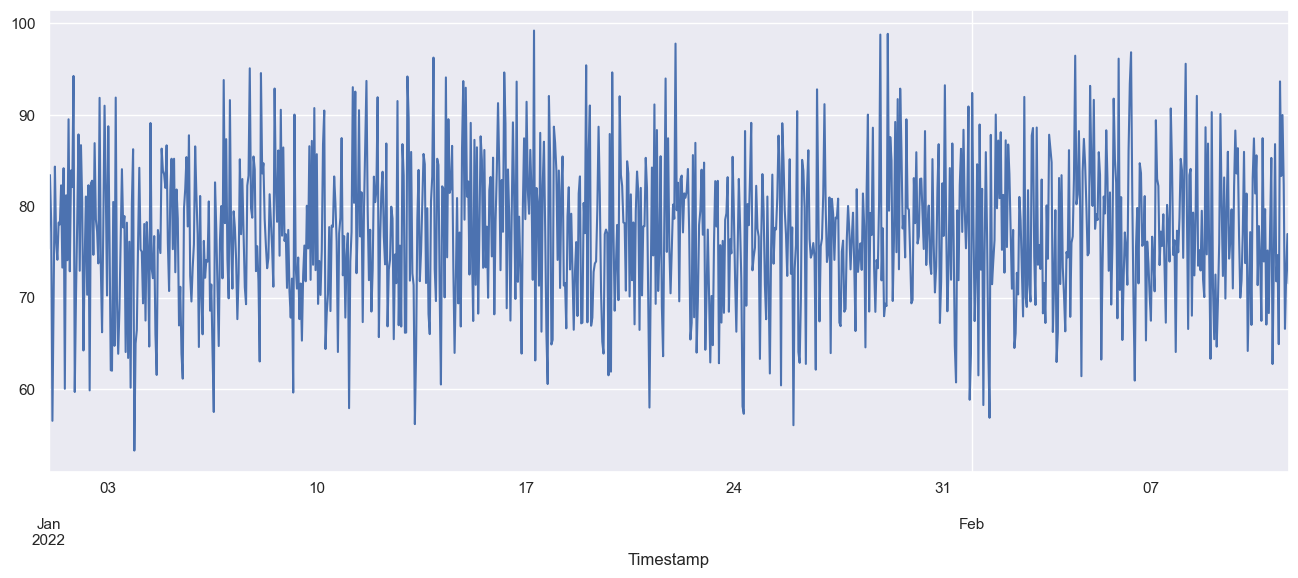

In [59]:
df['EnergyConsumption'].plot(figsize=(16,6))

## Based on the exploratory data analysis (EDA) conducted so far, the time series appears to be stationary. However, to confirm this observation with statistical evidence, I will perform a formal stationarity test on the data which is the Augmented Dickey-Fuller (ADF) test — to validate whether the statistical properties (mean, variance, autocorrelation) remain constant over time.

# Augmented Dickey-Fuller Test

In [62]:
## creating the Augmented Dickey-Fuller Test function

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())        
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [79]:
adf_test(df['RenewableEnergy'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -31.932256
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [65]:
adf_test(df['Humidity'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.647441e+01
p-value                 2.267368e-29
# lags used             2.000000e+00
# observations          9.970000e+02
critical value (1%)    -3.436926e+00
critical value (5%)    -2.864443e+00
critical value (10%)   -2.568316e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [67]:
adf_test(df['Temperature'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -32.226920
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [68]:
adf_test(df['SquareFootage'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -32.364591
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [69]:
adf_test(df['EnergyConsumption'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -31.576934
p-value                   0.000000
# lags used               0.000000
# observations          999.000000
critical value (1%)      -3.436913
critical value (5%)      -2.864437
critical value (10%)     -2.568313
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Insight 
Based on the results of the statistical stationarity test, the numerical features in the dataset are confirmed to be stationary. This means their statistical properties—such as mean and variance—remain constant over time. As a result, there is no need to apply differencing or other transformations to make the series stationary before modeling.

# Checking for correlation between numerical features and energyconsumption using cross correlation 

## cross- correlation

In [71]:
df['Temperature'].corr(df['EnergyConsumption'])


0.6964103773314035

In [72]:
df['SquareFootage'].corr(df['EnergyConsumption'])

-0.001129061410164112

In [74]:
df['Humidity'].corr(df['EnergyConsumption'])

-0.09358284322013086

In [75]:
df['Occupancy'].corr(df['EnergyConsumption'])

0.18658043461482587

In [76]:
df['RenewableEnergy'].corr(df['EnergyConsumption'])

0.08115968233976739

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2022-01-01 00:00:00 to 2022-02-11 15:00:00
Freq: h
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1000 non-null   float64
 1   Humidity           1000 non-null   float64
 2   SquareFootage      1000 non-null   float64
 3   Occupancy          1000 non-null   int64  
 4   HVACUsage          1000 non-null   float64
 5   LightingUsage      1000 non-null   float64
 6   RenewableEnergy    1000 non-null   float64
 7   DayOfWeek          1000 non-null   float64
 8   Holiday            1000 non-null   float64
 9   EnergyConsumption  1000 non-null   float64
 10  Hour               1000 non-null   int32  
 11  7-day-SMA          994 non-null    float64
 12  14-day-SMA         987 non-null    float64
 13  EWMA-14            1000 non-null   float64
 14  SES14              1000 non-null   object 
dtypes: float64(12), int32(1), in

In [78]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.982026,2.836850,20.007565,22.645070,24.751637,27.418174,29.998671
Humidity,1000.0,45.395412,8.518905,30.015975,38.297722,45.972116,52.420066,59.969085
SquareFootage,1000.0,1500.052488,288.418873,1000.512661,1247.108548,1507.967426,1740.340165,1999.982252
Occupancy,1000.0,4.581000,2.865598,0.000000,2.000000,5.000000,7.000000,9.000000
HVACUsage,1000.0,0.492000,0.500186,0.000000,0.000000,0.000000,1.000000,1.000000
LightingUsage,1000.0,0.491000,0.500169,0.000000,0.000000,0.000000,1.000000,1.000000
RenewableEnergy,1000.0,15.132813,8.745917,0.006642,7.628385,15.072296,22.884064,29.965327
DayOfWeek,1000.0,2.992000,2.006979,0.000000,1.000000,3.000000,5.000000,6.000000
Holiday,1000.0,0.467000,0.499159,0.000000,0.000000,0.000000,1.000000,1.000000
EnergyConsumption,1000.0,77.055873,8.144112,53.263278,71.544690,76.943696,82.921742,99.201120


In [27]:
df.isna().sum()

Temperature          0
Humidity             0
SquareFootage        0
Occupancy            0
HVACUsage            0
LightingUsage        0
RenewableEnergy      0
DayOfWeek            0
Holiday              0
EnergyConsumption    0
Hour                 0
dtype: int64

# Final Insight and Model Selection

Recall that i performed Granger causality tests to determine whether any of the available features could help forecast future values of EnergyConsumption. The results showed that all features had p-values greater than 0.05, which indicates the following:

- None of the features significantly Granger-cause EnergyConsumption.

- They are unlikely to improve the forecasting performance in a linear modeling context.

Due to this, I will not proceed with models like VAR (Vector Autoregression) or VARMA (Vector Autoregressive Moving Average), even though these models are designed for multivariate time series. This decision is based on the fact that the Granger causality test failed to reject the null hypothesis for all features — meaning their past values do not help predict the target variable.

As a result, I will simplify the modeling pipeline by removing all other features and focus on forecasting using only the EnergyConsumption series. I will train a univariate ARIMA model, which is well-suited for capturing the temporal dynamics, trend, and seasonality of a single time series.

However, I also recognize that Granger causality tests only detect linear relationships. It's possible that the features still hold nonlinear or lagged dependencies that traditional statistical models can't capture. Therefore:

- I will also build and evaluate a deep learning model like  LSTM using all features.
-  These models are capable of learning complex temporal patterns and interactions, which may improve predictive performance even when statistical tests suggest otherwise.

# Model Development Phase